# 03 - Feature Selection (RF Importance, RFE, Chi2)

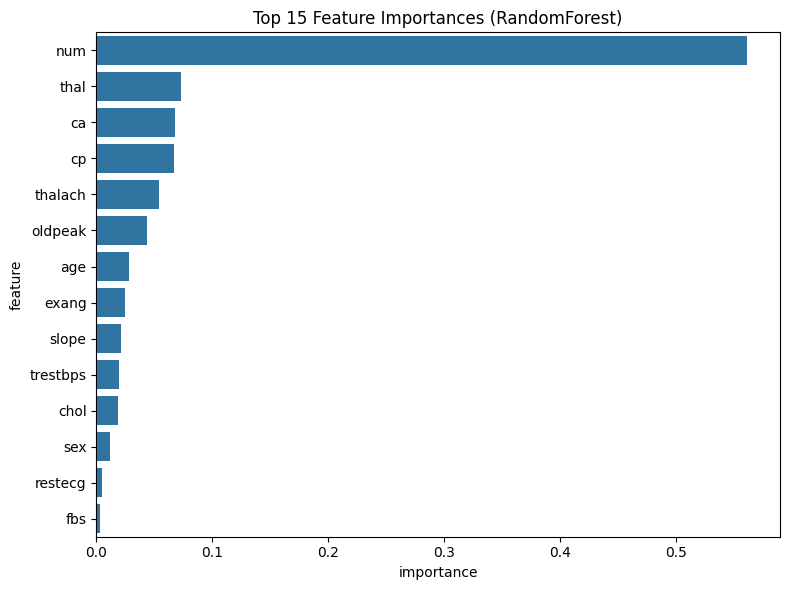

RFE selected feature indices (transformed space): [ 1  2  3  5  8 11 12 13]
    feature_idx       chi2             p
13           13  83.769784  5.558797e-20
12           12  44.877965  2.097045e-11
8             8  38.052613  6.886243e-10
11           11  28.038394  1.189323e-07
9             9  11.382669  7.413251e-04
10           10  10.984336  9.188519e-04
1             1   7.432845  6.404399e-03
2             2   7.384879  6.577449e-03
6             6   4.322448  3.761276e-02
7             7   2.670638  1.022151e-01


In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, chi2
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

CLEAN_PATH = Path.cwd().parents[0] / 'data' / 'heart_disease_clean.csv'
df = pd.read_csv(CLEAN_PATH)

X = df.drop(columns=['target'])
y = df['target']

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess_for_rf = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))]), num_cols),
    ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
])

rf = RandomForestClassifier(n_estimators=300, random_state=42)
pipe_rf = Pipeline(steps=[('prep', preprocess_for_rf), ('rf', rf)])
pipe_rf.fit(X, y)

# Get feature names
ohe = pipe_rf.named_steps['prep'].named_transformers_['cat'].named_steps.get('onehot', None)
cat_feat_names = []
if cat_cols and ohe is not None:
    cat_feat_names = ohe.get_feature_names_out(cat_cols).tolist()
feat_names = num_cols + cat_feat_names

importances = pipe_rf.named_steps['rf'].feature_importances_
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=imp_df.head(15))
plt.title('Top 15 Feature Importances (RandomForest)')
plt.tight_layout()
plt.savefig('../results/feature_importances_rf.png', dpi=150)
plt.show()

# RFE with Logistic Regression
preprocess_for_lr = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())]), num_cols),
    ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
])
lr = LogisticRegression(max_iter=1000, n_jobs=None)
pipe_lr = Pipeline(steps=[('prep', preprocess_for_lr), ('lr', lr)])

# For RFE, we need a flat matrix; fit a temporary transformed X
X_trans = pipe_lr.named_steps['prep'].fit_transform(X, y)
est = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=est, n_features_to_select=8)
rfe.fit(X_trans, y)
print('RFE selected feature indices (transformed space):', np.where(rfe.support_)[0])

# Chi-square (for non-negative features; use MinMax to ensure non-negativity)
preprocess_for_chi2 = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                           ('scale', MinMaxScaler())]), num_cols),
    ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
])
X_chi = preprocess_for_chi2.fit_transform(X, y)
chi_vals, p_vals = chi2(X_chi, y)
chi_df = pd.DataFrame({'feature_idx': range(X_chi.shape[1]), 'chi2': chi_vals, 'p': p_vals}).sort_values('chi2', ascending=False)
print(chi_df.head(10))
